In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv('data/Tweets.csv')

In [3]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
cat_id = {
    'neutral': 1,
    'negative': 0,
    'positive': 2
}

df['class'] = df['sentiment'].map(cat_id)

In [7]:
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [30]:
# Hyperparams
BATCH_SIZE = 128
NUM_EPOCHS = 160
MAX_FEATURES = 10

In [9]:
# Embeddings model
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
sentences = ["Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/transformers/models/mpnet/modeling_mpnet.py:1051: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:452.)
  incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask


(768,)


In [11]:
# embedding the df
X = emb_model.encode(df['text'].values)

In [12]:
with open("tweets_X.pkl", "wb") as output_file:
  pickle.dump(X, output_file)

In [14]:
with open("tweets_X.pkl", "rb") as input_file:
  X = pickle.load(input_file)

In [15]:
y = df['class'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [18]:
train_ds = SentimentData(X=X_train, y=y_train)

test_ds = SentimentData(X=X_test, y=y_test)

In [21]:
# Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=15000)

In [26]:
# Model building
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

# Model, Loss, and Optimizer

In [31]:
model = SentimentModel(NUM_FEATURES=X_train.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [32]:
# Model training loop

train_losses = []

for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e+1}, Loss: {curr_loss}")

Epoch 1, Loss: 173.25608414411545
Epoch 2, Loss: 136.51470059156418
Epoch 3, Loss: 128.73412269353867
Epoch 4, Loss: 126.04770791530609
Epoch 5, Loss: 124.45386338233948
Epoch 6, Loss: 123.36188501119614
Epoch 7, Loss: 122.45333844423294
Epoch 8, Loss: 121.78646099567413
Epoch 9, Loss: 121.10618823766708
Epoch 10, Loss: 120.45433473587036
Epoch 11, Loss: 119.9791749715805
Epoch 12, Loss: 119.28361856937408
Epoch 13, Loss: 118.73058170080185
Epoch 14, Loss: 118.13171809911728
Epoch 15, Loss: 117.59503227472305
Epoch 16, Loss: 117.11957037448883
Epoch 17, Loss: 116.68004608154297
Epoch 18, Loss: 116.2233167886734
Epoch 19, Loss: 115.72534936666489
Epoch 20, Loss: 115.3547887802124
Epoch 21, Loss: 114.96706223487854
Epoch 22, Loss: 114.59680128097534
Epoch 23, Loss: 114.11391282081604
Epoch 24, Loss: 113.7494820356369
Epoch 25, Loss: 113.42227840423584
Epoch 26, Loss: 112.98215344548225
Epoch 27, Loss: 112.64280891418457
Epoch 28, Loss: 112.33467537164688
Epoch 29, Loss: 111.9646547436714

# Looking at training results

<Axes: >

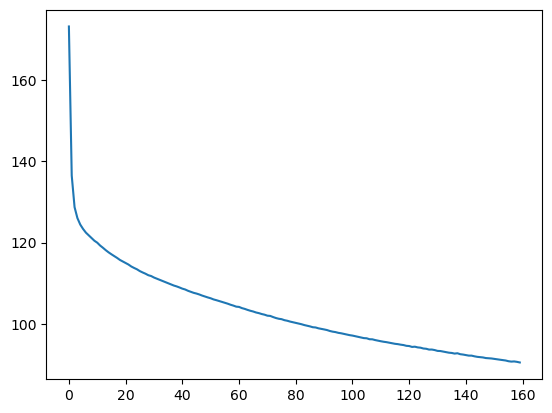

In [33]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)

# Model Performance

In [34]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)

In [35]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [36]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
f"The accuracy of the model is {np.round(acc,3)*100}%."

'The accuracy of the model is 67.7%.'

In [37]:
## Naive classifier to show model does indeed perform better than the most likely scenario

most_common_count = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_count / len(y_test) * 100, 1)} %")

Naive Classifier: 41.4 %


<Axes: >

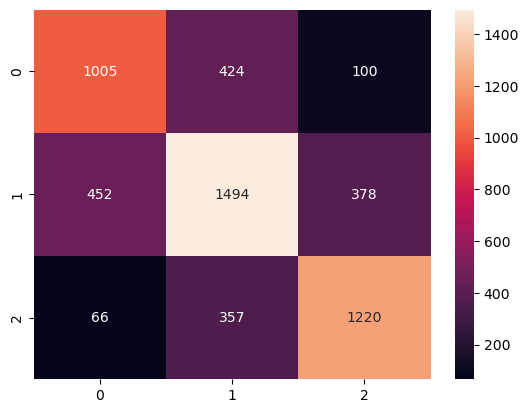

In [39]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")